In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pickle

from haloflow import config as C

In [3]:
C.setup_plotting_config()

In [4]:
dat_dir = C.get_dat_dir()
data_dir = dat_dir + 'hf2/npe/'

In [5]:
sims = ['TNG_ALL', 'Simba100', 'Eagle100']
obs = 'mags_morph_extra'

In [6]:
title_names = {
    'TNG_ALL': 'TNG',
    'Eagle100': 'Eagle',
    'Simba100': 'Simba'
}

In [7]:
# SIMBA -> TNG_ALL
# Train Sim = Simba100
# Test Sim = TNG_ALL, DANN Sim = TNG_ALL

In [8]:
with open('../ml4ps/bias_estimate_results_new.pkl', 'rb') as f:
    bias_results = pickle.load(f)

In [9]:
for key in bias_results.keys():
    try:
        print(np.median(bias_results[key]['bias'][:, 1]), key)
    except:
        pass

0.9621701242127336 hfd_TNG_ALL_Simba100
0.893701909894328 hfm_TNG_ALL_Simba100
1.3390138588122782 hfd_TNG_ALL_Eagle100
0.8785387300903926 hfm_TNG_ALL_Eagle100
0.8473258637526438 hfd_Simba100_TNG_ALL
0.5847848581830432 hfm_Simba100_TNG_ALL
1.2219677743701505 hfd_Simba100_Eagle100
0.6282184257749637 hfm_Simba100_Eagle100
1.396048251608253 hfd_Eagle100_TNG_ALL
1.0676059671426983 hfm_Eagle100_TNG_ALL
1.415821857577399 hfd_Eagle100_Simba100
1.1853130321551992 hfm_Eagle100_Simba100


In [21]:
# baseline
# "can you show the intrinsic scatter in true halo masses at fixed true stellar mass"
def intrinsic_scatter(y_true, bins, robust=False):
    # get intrinsic scatter of true Mh at fixed true M*
    mstar_true = y_true[:, 0]
    mhalo_true = y_true[:, 1]

    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sigma = []
    counts = []

    for lo, hi in zip(bins[:-1], bins[1:]):
        in_bin = (mstar_true >= lo) & (mstar_true < hi)
        counts.append(np.sum(in_bin))
        if np.sum(in_bin) < 0:
            sigma.append(np.nan)
            continue
        
        if robust:
            q16, q50, q84 = np.quantile(mhalo_true[in_bin], [0.16, 0.5, 0.84])
            scatter = 0.5 * (q84 - q16)
        else:
            scatter = np.std(mhalo_true[in_bin])
        sigma.append(scatter)
    
    return bin_centers, np.array(sigma), np.array(counts)


# "For the curves of the models, the x axis should be predicted stellar mass."
def scatter_mh_binned_pred_mstar(results, bins):
    y_true = results['y_true']
    y_nde_q0, y_nde_q1, y_nde_q2 = np.quantile(results['y_nde'], [0.16, 0.5, 0.84], axis=1)

    mstar_pred = y_nde_q1[:, 0]
    mh_pred = y_nde_q1[:, 1]
    mh_true = y_true[:, 1]

    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    scatter_per_bin, counts = [], []

    for lo, hi in zip(bins[:-1], bins[1:]):
        in_bin = (mstar_pred >= lo) & (mstar_pred < hi)
        counts.append(np.sum(in_bin))

        if np.sum(in_bin) > 0:
            scatter = np.std((mh_pred[in_bin] - mh_true[in_bin]), ddof=1)
        else:
            scatter = np.nan
        scatter_per_bin.append(scatter)
    
    return bin_centers, np.array(scatter_per_bin), np.array(counts)

def scatter_mh_binned_true_mh(results, bins):
    y_true = results['y_true']
    y_nde_q0, y_nde_q1, y_nde_q2 = np.quantile(results['y_nde'], [0.16, 0.5, 0.84], axis=1)

    mh_true = y_true[:, 1]
    mh_pred = y_nde_q1[:, 1]

    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    scatter_per_bin, counts = [], []

    for lo, hi in zip(bins[:-1], bins[1:]):
        in_bin = (mh_true >= lo) & (mh_true < hi)
        counts.append(np.sum(in_bin))

        if np.sum(in_bin) > 0:
            scatter = np.std((mh_pred[in_bin] - mh_true[in_bin]), ddof=1)
        else:
            scatter = np.nan
        scatter_per_bin.append(scatter)
    
    return bin_centers, np.array(scatter_per_bin), np.array(counts)


In [22]:
bins_mstar = np.linspace(10, 13, 10)
bins_mh = np.linspace(11, 15, 10)

results = bias_results['hfd_TNG_ALL_Simba100']

# baseline intrinsic scatter
baseline_x, baseline_sigma, baseline_N = intrinsic_scatter(
    results['y_true'], bins_mstar, robust=False
)

# model curves: scatter binned by predicted stellar mass
x_hfm, y_hfm, N_hfm = scatter_mh_binned_pred_mstar(
    bias_results['hfm_TNG_ALL_Simba100'], bins_mstar
)
x_hfd, y_hfd, N_hfd = scatter_mh_binned_pred_mstar(
    bias_results['hfd_TNG_ALL_Simba100'], bins_mstar
)

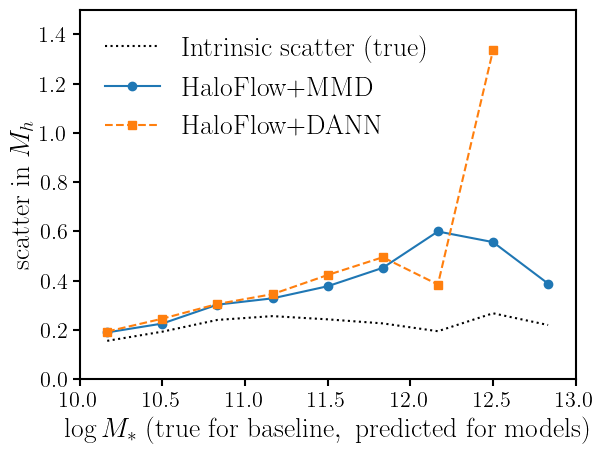

In [23]:
plt.plot(baseline_x, baseline_sigma, linestyle=':', color='k', label='Intrinsic scatter (true)')
plt.plot(x_hfm, y_hfm, marker='o', linestyle='-', color='C0', label='HaloFlow+MMD')
plt.plot(x_hfd, y_hfd, marker='s', linestyle='--', color='C1', label='HaloFlow+DANN')
plt.xlabel(r'$\log M_* \; (\mathrm{true\ for\ baseline,\ predicted\ for\ models})$')
plt.ylabel('scatter in $M_h$')
plt.xlim(10, 13)
plt.ylim(0, 1.5)
plt.legend()


<>:28: SyntaxWarning: invalid escape sequence '\l'
<>:30: SyntaxWarning: invalid escape sequence '\R'
<>:28: SyntaxWarning: invalid escape sequence '\l'
<>:30: SyntaxWarning: invalid escape sequence '\R'
/var/folders/4v/k4xpjdyx3f1_c95lc_dlyhkr0000gq/T/ipykernel_32944/3818811112.py:28: SyntaxWarning: invalid escape sequence '\l'
  ax[i, j].set_xlabel('$\log M_*$ true for baseline, \n predicted for models')
/var/folders/4v/k4xpjdyx3f1_c95lc_dlyhkr0000gq/T/ipykernel_32944/3818811112.py:30: SyntaxWarning: invalid escape sequence '\R'
  ax[i, j].text(0.5, 0.05, f'{title_names[train_sim]} $\Rightarrow$ {title_names[test_sim]}',
/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/ng27753/Astronomy_Research/haloflow/venv/lib/python3.13/site-packages/numpy/_core/_methods.py:184: RuntimeWarning: invalid value encountered in di

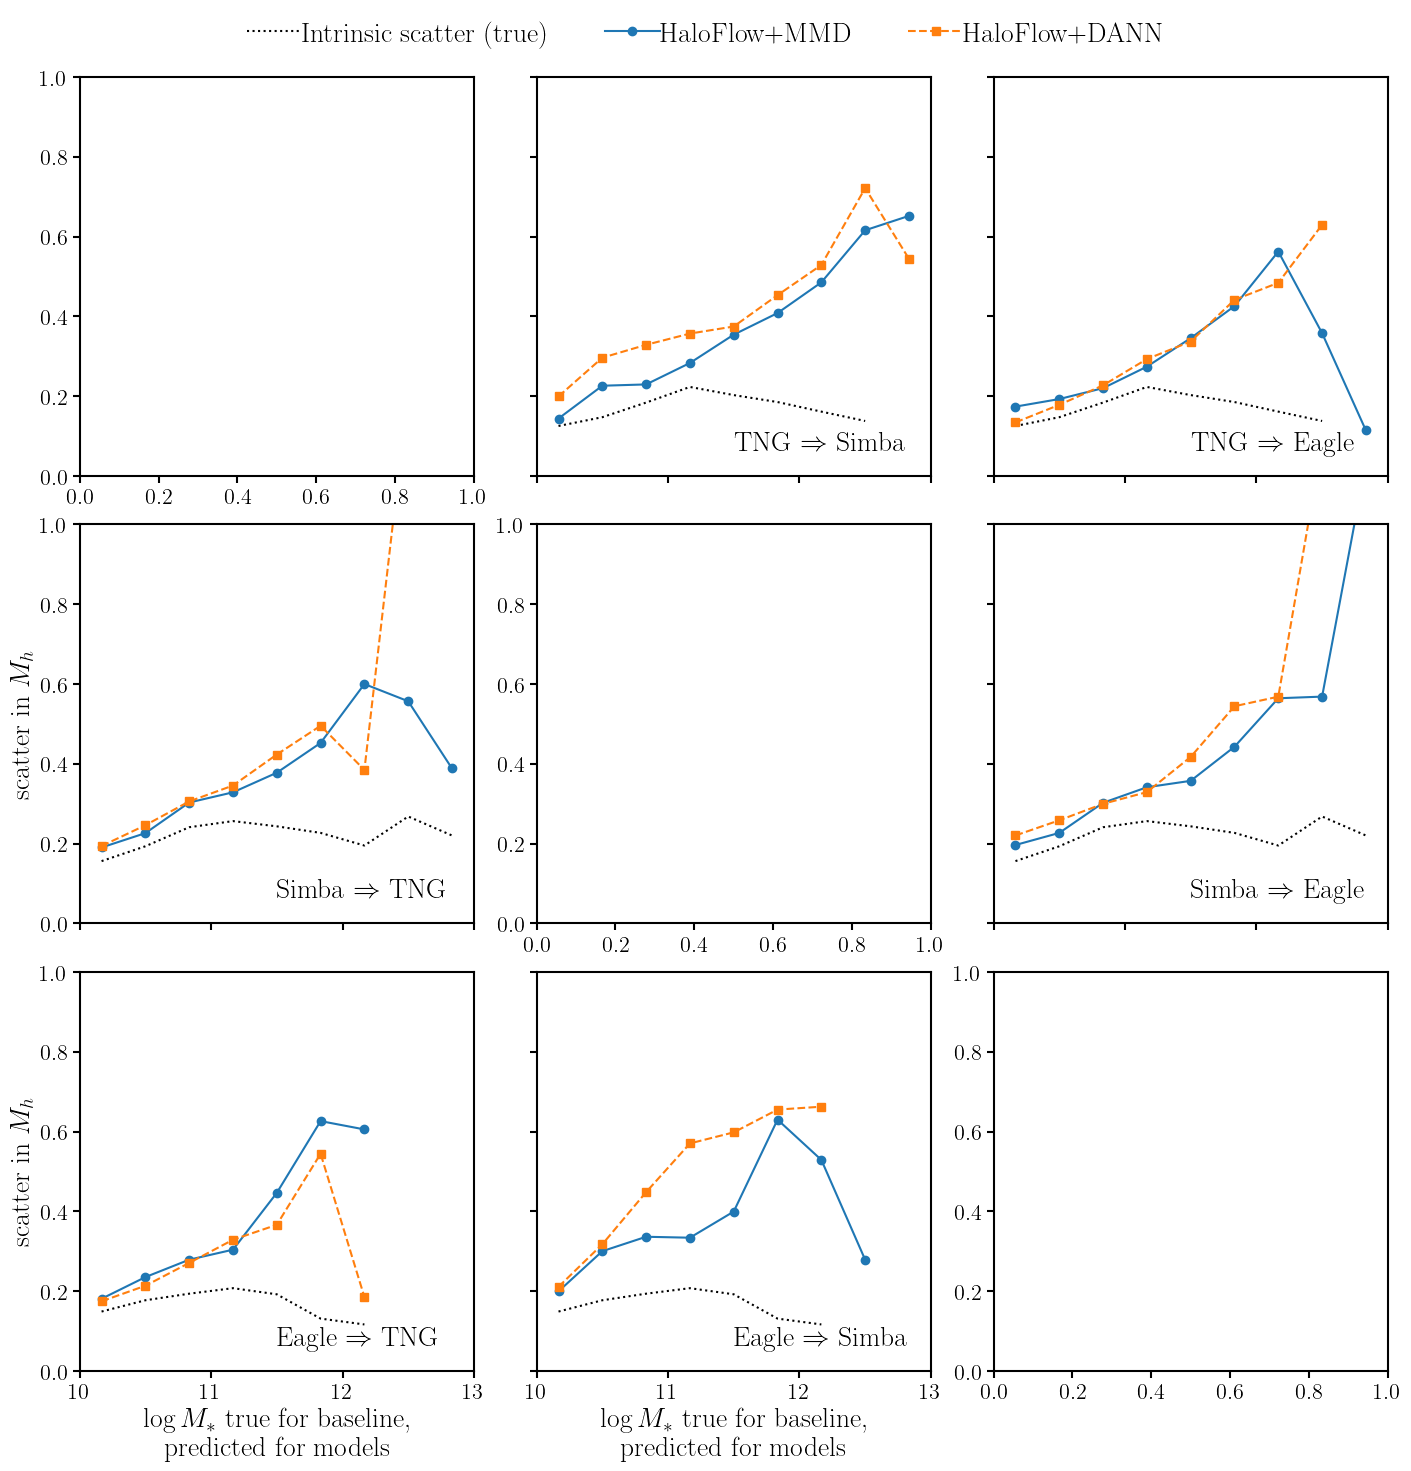

In [24]:
fig, ax = plt.subplots(len(sims), len(sims), figsize=(14, 14), constrained_layout=True)

for i, train_sim in enumerate(sims):
    for j, test_sim in enumerate(sims):
        if train_sim == test_sim:
            # ax[i, j].axis('off')
            continue

        results_hfm = bias_results[f'hfm_{test_sim}_{train_sim}']
        results_hfd = bias_results[f'hfd_{test_sim}_{train_sim}']

        # baseline 
        baseline_x, baseline_sigma, baseline_N = intrinsic_scatter(
            results_hfm['y_true'], bins_mstar, robust=False
        )

        # model curves: scatter binned by predicted stellar mass
        x_hfm, y_hfm, N_hfm = scatter_mh_binned_pred_mstar(
            results_hfm, bins_mstar
        )
        x_hfd, y_hfd, N_hfd = scatter_mh_binned_pred_mstar(
            results_hfd, bins_mstar
        )
        
        ax[i, j].plot(baseline_x, baseline_sigma, linestyle=':', color='k', label='Intrinsic scatter (true)')
        ax[i, j].plot(x_hfm, y_hfm, marker='o', linestyle='-', color='C0', label='HaloFlow+MMD')
        ax[i, j].plot(x_hfd, y_hfd, marker='s', linestyle='--', color='C1', label='HaloFlow+DANN')
        ax[i, j].set_xlabel('$\log M_*$ true for baseline, \n predicted for models')
        ax[i, j].set_ylabel('scatter in $M_h$')
        ax[i, j].text(0.5, 0.05, f'{title_names[train_sim]} $\Rightarrow$ {title_names[test_sim]}',
                      transform=ax[i, j].transAxes, ha='left', va='bottom', fontsize=20)
        
        ax[i, j].set_xlim(10, 13)
        ax[i, j].set_ylim(0, 1)

        ax[i, j].label_outer()

handles, labels = ax[0, 1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=20, bbox_to_anchor=(0.5, 1.05), frameon=False, fancybox=True, handletextpad=0)

<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\R'
<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\R'
/var/folders/4v/k4xpjdyx3f1_c95lc_dlyhkr0000gq/T/ipykernel_32944/356645062.py:23: SyntaxWarning: invalid escape sequence '\l'
  ax[i, j].set_xlabel('$\log M_h (true)$')
/var/folders/4v/k4xpjdyx3f1_c95lc_dlyhkr0000gq/T/ipykernel_32944/356645062.py:25: SyntaxWarning: invalid escape sequence '\R'
  ax[i, j].text(0.5, 0.05, f'{title_names[train_sim]} $\Rightarrow$ {title_names[test_sim]}',


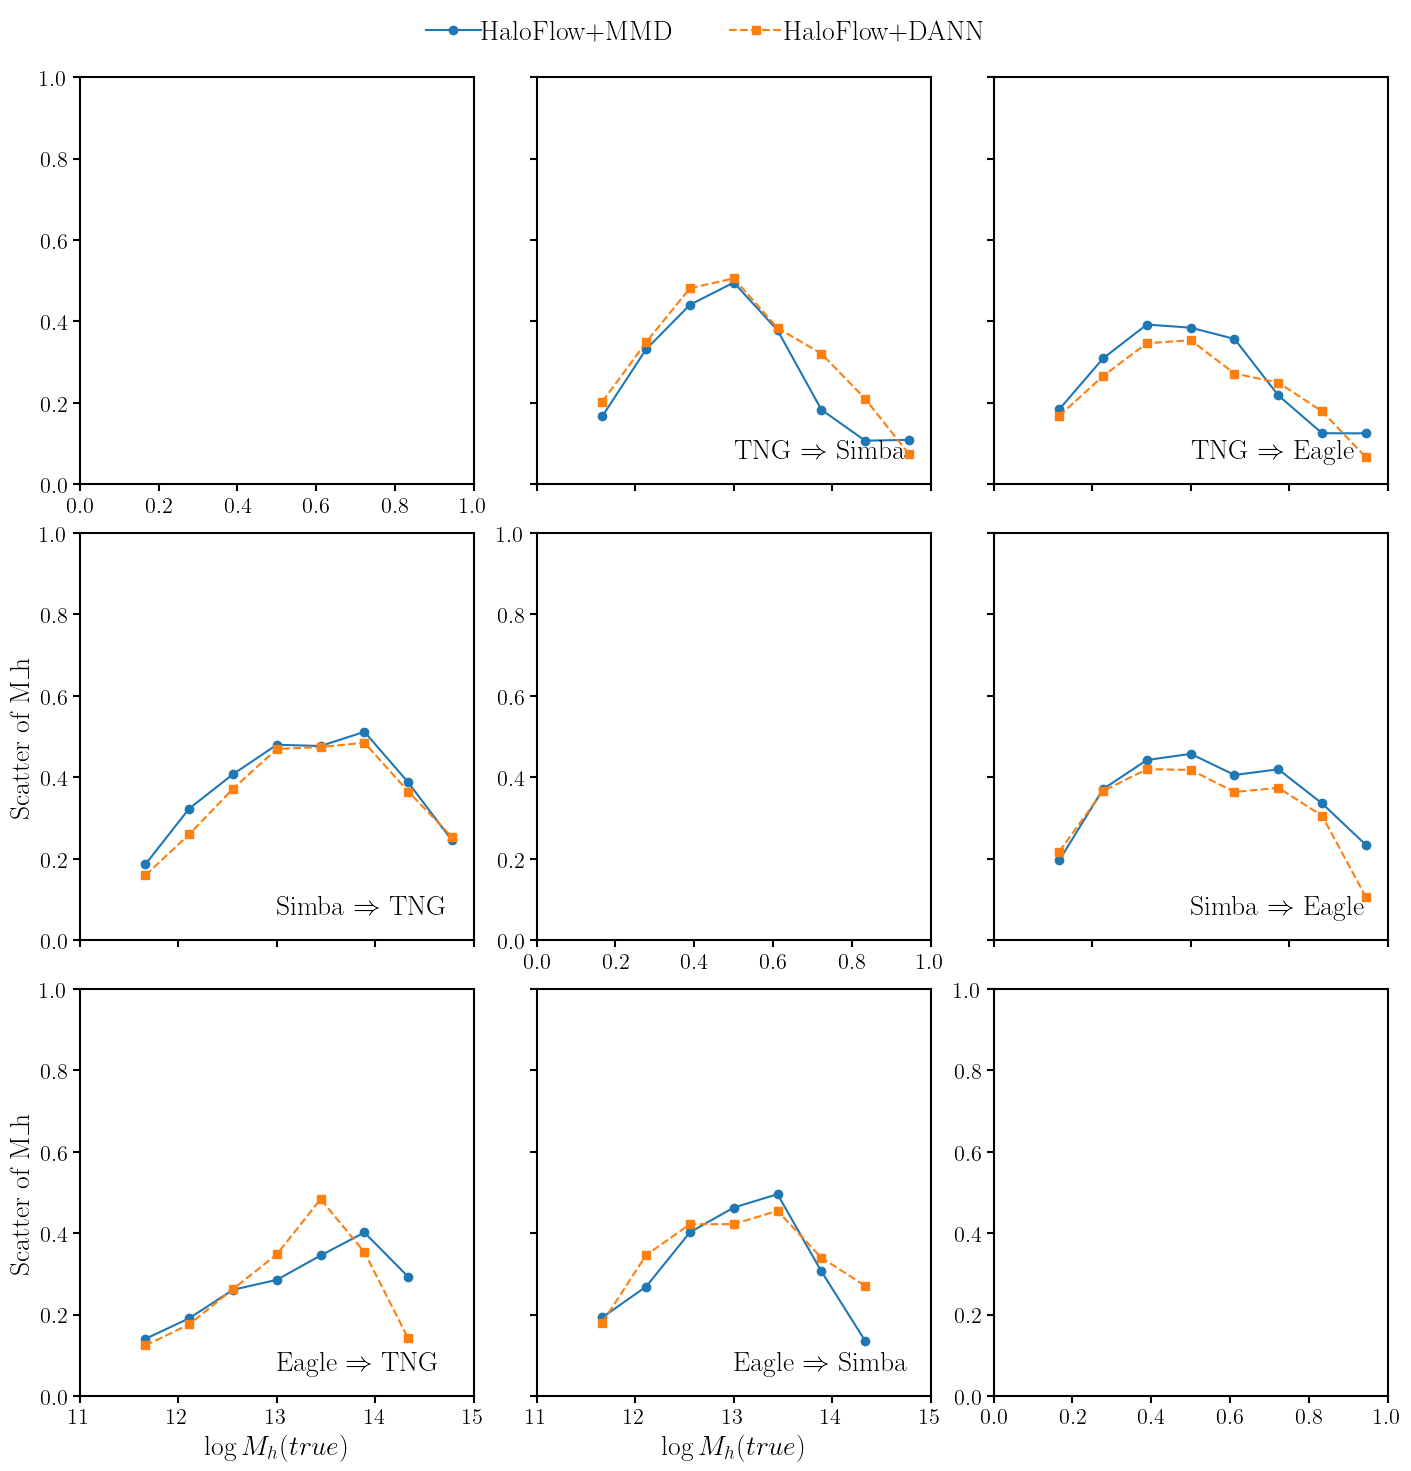

In [26]:
fig, ax = plt.subplots(len(sims), len(sims), figsize=(14, 14), constrained_layout=True)

for i, train_sim in enumerate(sims):
    for j, test_sim in enumerate(sims):
        if train_sim == test_sim:
            # ax[i, j].axis('off')
            continue

        results_hfm = bias_results[f'hfm_{test_sim}_{train_sim}']
        results_hfd = bias_results[f'hfd_{test_sim}_{train_sim}']

        bin_centers, scatter_bin_hfm, N = scatter_mh_binned_true_mh(
            results_hfm, bins_mh
        )
        bin_centers, scatter_bin_hfd, N = scatter_mh_binned_true_mh(
            results_hfd, bins_mh
        )
        

        ax[i, j].plot(bin_centers, scatter_bin_hfm, marker='o', linestyle='-', color='C0', label='HaloFlow+MMD')
        ax[i, j].plot(bin_centers, scatter_bin_hfd, marker='s', linestyle='--', color='C1', label='HaloFlow+DANN')
        # ax[i, j].legend()
        ax[i, j].set_xlabel('$\log M_h (true)$')
        ax[i, j].set_ylabel('Scatter of M_h')
        ax[i, j].text(0.5, 0.05, f'{title_names[train_sim]} $\Rightarrow$ {title_names[test_sim]}',
                      transform=ax[i, j].transAxes, ha='left', va='bottom', fontsize=20)
        
        ax[i, j].set_xlim(11, 15)
        ax[i, j].set_ylim(0, 1)

        ax[i, j].label_outer()

handles, labels = ax[0, 1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=20, bbox_to_anchor=(0.5, 1.05), frameon=False, fancybox=True, handletextpad=0)